## ANOVA

ANOVA is a statistical method used to **compare the means of two or more groups** by analyzing between- and within-group variance.  ANOVA is particularly *useful when dealing with multiple groups*, as it allows for **simultaneous comparisons**, reducing the risk of Type I error that could occur with multiple individual t-test.

### Interpret Results

ONE-WAY ANOVA:
- Tests whether group means differ significantly
- H₀: μ₁ = μ₂ = μ₃ (all campaign means equal)
- H₁: At least one mean differs
- If p < 0.05: Reject H₀, campaigns have different conversion rates

TWO-WAY ANOVA:
- Tests three hypotheses:
  1. Main effect of Factor 1 (Campaign): Do campaigns differ overall?
  2. Main effect of Factor 2 (Gender): Do genders differ overall?  
  3. Interaction effect: Does the campaign effect depend on gender?

- Interaction interpretation:
  * No interaction: Campaign effects are consistent across genders
  * Significant interaction: Campaign effects differ by gender
  * Look at interaction plot - parallel lines = no interaction

### ANOVA from packages

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(326)

# Reusable helper functions
def generate_one_way_data(group_means, group_std=1.0, n_per_group=30):
    """
    Generate sample data for one-way ANOVA
    
    Parameters:
    - group_means: list of means for each group
    - group_std: standard deviation within groups
    - n_per_group: sample size per group
    
    Returns:
    - DataFrame with 'value' and 'group' columns
    """
    data = []
    
    for i, mean in enumerate(group_means):
        # Generate samples from normal distribution
        samples = np.random.normal(mean, group_std, n_per_group)
        group_data = pd.DataFrame({
            'value': samples,
            'group': f'Group_{i+1}'
        })
        data.append(group_data)
    
    return pd.concat(data, ignore_index=True)

def generate_two_way_data(factor1_levels, factor2_levels, cell_means, cell_std=1.0, n_per_cell=15):
    """
    Generate sample data for two-way ANOVA
    
    Parameters:
    - factor1_levels: list of level names for factor 1
    - factor2_levels: list of level names for factor 2  
    - cell_means: 2D array of means for each combination
    - cell_std: standard deviation within cells
    - n_per_cell: sample size per cell
    
    Returns:
    - DataFrame with 'value', 'factor1', 'factor2' columns
    """
    data = []
    
    for i, f1_level in enumerate(factor1_levels):
        for j, f2_level in enumerate(factor2_levels):
            samples = np.random.normal(cell_means[i][j], cell_std, n_per_cell)
            cell_data = pd.DataFrame({
                'value': samples,
                'factor1': f1_level,
                'factor2': f2_level
            })
            data.append(cell_data)
    
    return pd.concat(data, ignore_index=True)

def plot_one_way_results(data, value_col, group_col):
    """Create visualization for one-way ANOVA results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Box plot
    sns.boxplot(data=data, x=group_col, y=value_col, ax=ax1)
    ax1.set_title('Distribution by Group')
    
    # Mean plot with error bars
    group_stats = data.groupby(group_col)[value_col].agg(['mean', 'std'])
    ax2.bar(group_stats.index, group_stats['mean'], yerr=group_stats['std'], capsize=5)
    ax2.set_title('Group Means with Standard Deviation')
    ax2.set_ylabel(value_col)
    
    plt.tight_layout()
    plt.show()

def plot_two_way_results(data, value_col, factor1_col, factor2_col):
    """Create visualization for two-way ANOVA results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Interaction plot
    for f2_level in data[factor2_col].unique():
        subset = data[data[factor2_col] == f2_level]
        means = subset.groupby(factor1_col)[value_col].mean()
        ax1.plot(means.index, means.values, marker='o', label=f2_level)
    
    ax1.set_xlabel(factor1_col)
    ax1.set_ylabel(f'Mean {value_col}')
    ax1.set_title('Interaction Plot')
    ax1.legend(title=factor2_col)
    
    # Heatmap of cell means
    pivot_data = data.pivot_table(values=value_col, 
                                 index=factor1_col, 
                                 columns=factor2_col, 
                                 aggfunc='mean')
    sns.heatmap(pivot_data, annot=True, fmt='.2f', ax=ax2)
    ax2.set_title('Cell Means Heatmap')
    
    plt.tight_layout()
    plt.show()

#### One-way ANOVA

ONE-WAY ANOVA EXAMPLE: Campaign Conversion Rates
Sample data:
   conversion_rate     campaign
0         0.115242  Traditional
1         0.081948  Traditional
2         0.063600  Traditional
3         0.080086  Traditional
4         0.086089  Traditional

Descriptive statistics:
              count      mean       std
campaign                               
Influencer       50  0.149674  0.029145
Social_Media     50  0.123360  0.026707
Traditional      50  0.073879  0.029419


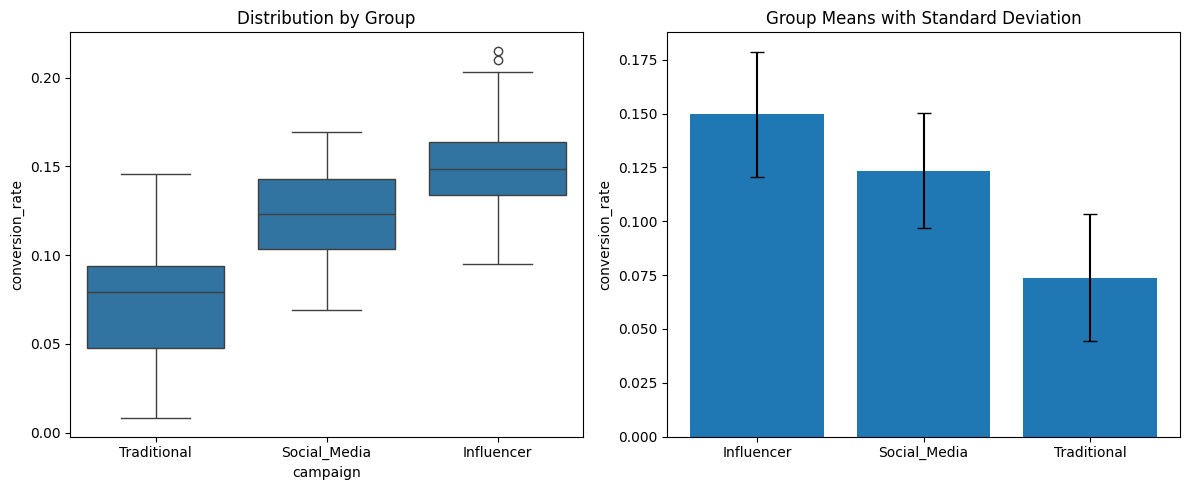

In [2]:
# =============================================================================
# EXAMPLE 1: ONE-WAY ANOVA - Campaign Conversion Rates
# =============================================================================

print("ONE-WAY ANOVA EXAMPLE: Campaign Conversion Rates")
print("=" * 50)

# Generate business data: 3 marketing campaigns
campaign_means = [0.08, 0.12, 0.15]  # Traditional, Social Media, Influencer
campaign_data = generate_one_way_data(
    group_means=campaign_means,
    group_std=0.03,
    n_per_group=50
)

# Business context naming
campaign_data.columns = ['conversion_rate', 'campaign']
campaign_data['campaign'] = campaign_data['campaign'].map({
    'Group_1': 'Traditional',
    'Group_2': 'Social_Media', 
    'Group_3': 'Influencer'
})

print("Sample data:")
print(campaign_data.head())
print(f"\nDescriptive statistics:")
print(campaign_data.groupby('campaign')['conversion_rate'].agg(['count', 'mean', 'std']))

# Visualize results
plot_one_way_results(campaign_data, 'conversion_rate', 'campaign')

In [3]:
print("="*30)
print("APPROACH 1: SCIPY.STATS")
print("="*30)

# Method 1: scipy.stats - Simple and direct
groups = [group['conversion_rate'].values for name, group in campaign_data.groupby('campaign')]
f_stat, p_val = f_oneway(*groups)

print(f"SciPy f_oneway results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.6f}")
print(f"Significant at α=0.05: {'Yes' if p_val < 0.05 else 'No'}")


APPROACH 1: SCIPY.STATS
SciPy f_oneway results:
F-statistic: 91.4841
p-value: 0.000000
Significant at α=0.05: Yes


In [4]:
# Method 2: statsmodels OLS - More detailed output

# Ensure data types are correct for statsmodels
campaign_data['conversion_rate'] = campaign_data['conversion_rate'].astype(float)
campaign_data['campaign'] = campaign_data['campaign'].astype(str)


# This treats ANOVA as a regression problem
model = ols('conversion_rate ~ campaign', data=campaign_data).fit()
print("OLS Regression Summary (ANOVA as Regression):")
print(model.summary())

# Extract ANOVA table from the regression
anova_table = anova_lm(model, typ=2)
print(f"\nANOVA Table:")
print(anova_table)

OLS Regression Summary (ANOVA as Regression):
                            OLS Regression Results                            
Dep. Variable:        conversion_rate   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     91.48
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           1.55e-26
Time:                        14:51:31   Log-Likelihood:                 322.62
No. Observations:                 150   AIC:                            -639.2
Df Residuals:                     147   BIC:                            -630.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [5]:
# Understanding the regression coefficients
print(f"\nRegression Coefficients Interpretation:")
print("Intercept = Mean of reference group (Influencer)")
print("Other coefficients = Difference from reference group")
print("\nCoefficients:")
for param, coef in model.params.items():
    print(f"{param}: {coef:.6f}")


Regression Coefficients Interpretation:
Intercept = Mean of reference group (Influencer)
Other coefficients = Difference from reference group

Coefficients:
Intercept: 0.149674
campaign[T.Social_Media]: -0.026314
campaign[T.Traditional]: -0.075794


We can see that here `coefficients + intercept = group mean`, in other word, the coefficients are measuring deviations from the reference group, which helps decide which group is better.

#### Two-way ANOVA



TWO-WAY ANOVA EXAMPLE: Campaign × Gender
Sample data:
   conversion_rate     campaign gender
0         0.023240  Traditional   Male
1         0.091898  Traditional   Male
2         0.065382  Traditional   Male
3         0.061062  Traditional   Male
4         0.076978  Traditional   Male

Cell means:
campaign      gender
Influencer    Female    0.168608
              Male      0.132802
Social_Media  Female    0.145561
              Male      0.101146
Traditional   Female    0.096505
              Male      0.072030
Name: conversion_rate, dtype: float64


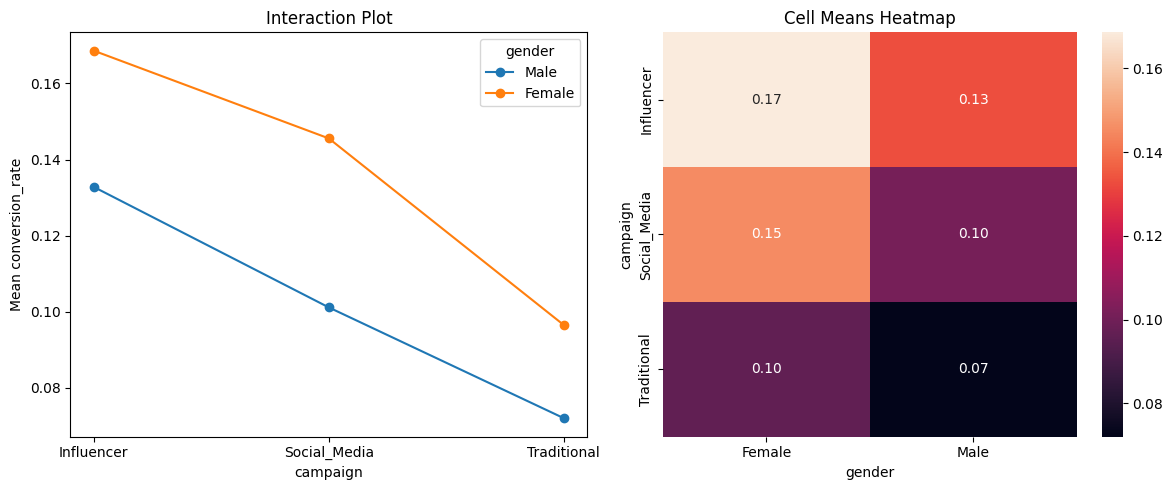

In [6]:
# =============================================================================
# EXAMPLE 2: TWO-WAY ANOVA - Campaign × Gender  
# =============================================================================

print("\n\nTWO-WAY ANOVA EXAMPLE: Campaign × Gender")
print("=" * 50)

# Generate interaction data
cell_means_matrix = [
    [0.07, 0.09],  # Traditional: Male, Female
    [0.10, 0.14],  # Social Media: Male, Female  
    [0.13, 0.17]   # Influencer: Male, Female
]

campaigns = ['Traditional', 'Social_Media', 'Influencer']
genders = ['Male', 'Female']

two_way_data = generate_two_way_data(
    factor1_levels=campaigns,
    factor2_levels=genders,
    cell_means=cell_means_matrix,
    cell_std=0.025,
    n_per_cell=25
)

two_way_data.columns = ['conversion_rate', 'campaign', 'gender']

# Ensure proper data types for statsmodels
two_way_data['conversion_rate'] = two_way_data['conversion_rate'].astype(float)
two_way_data['campaign'] = two_way_data['campaign'].astype(str)
two_way_data['gender'] = two_way_data['gender'].astype(str)

print("Sample data:")
print(two_way_data.head())
print(f"\nCell means:")
print(two_way_data.groupby(['campaign', 'gender'])['conversion_rate'].mean())

# Visualize data
plot_two_way_results(two_way_data, 'conversion_rate', 'campaign', 'gender')

In [7]:
print("\n" + "="*30)
print("APPROACH 2: STATSMODELS OLS")
print("="*30)

# Two-way ANOVA using OLS
# Formula syntax: outcome ~ factor1 + factor2 + factor1:factor2
model_2way = ols('conversion_rate ~ campaign + gender + campaign:gender', 
                 data=two_way_data).fit()

print("Two-Way ANOVA as Regression:")
print(model_2way.summary())

# ANOVA table - this is where the magic happens
anova_2way = anova_lm(model_2way, typ=2)
print(f"\nTwo-Way ANOVA Table:")
print(anova_2way)

# Interpretation of effects
print(f"\nEffect Interpretations:")
print(f"Campaign main effect p-value: {anova_2way.loc['campaign', 'PR(>F)']:.6f}")
print(f"Gender main effect p-value: {anova_2way.loc['gender', 'PR(>F)']:.6f}")  
print(f"Interaction effect p-value: {anova_2way.loc['campaign:gender', 'PR(>F)']:.6f}")

# Calculate effect sizes (eta-squared)
ss_total = anova_2way['sum_sq'].sum()
print(f"\nEffect Sizes (η²):")
for effect in anova_2way.index[:-1]:  # Exclude residual
    eta_squared = anova_2way.loc[effect, 'sum_sq'] / ss_total
    print(f"{effect}: {eta_squared:.4f}")


APPROACH 2: STATSMODELS OLS
Two-Way ANOVA as Regression:
                            OLS Regression Results                            
Dep. Variable:        conversion_rate   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     45.73
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           4.25e-28
Time:                        14:51:31   Log-Likelihood:                 335.24
No. Observations:                 150   AIC:                            -658.5
Df Residuals:                     144   BIC:                            -640.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

### ANOVA From scratch

In this section, I implemented ANOVA test by calculating the test statistics ourselves.

#### One-way ANOVA

In [8]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(326)

In [9]:
# =============================================================================
# EXAMPLE 1: ONE-WAY ANOVA - Campaign Conversion Rates
# =============================================================================

print("ONE-WAY ANOVA EXAMPLE: Campaign Conversion Rates")
print("=" * 50)

# Business scenario: Testing 3 marketing campaigns
# Campaign A: Traditional ads (lower conversion)
# Campaign B: Social media ads (medium conversion)  
# Campaign C: Influencer ads (higher conversion)

campaign_means = [0.08, 0.12, 0.15]  # Conversion rates
campaign_data = generate_one_way_data(
    group_means=campaign_means,
    group_std=0.03,
    n_per_group=50
)

# Rename columns for business context
campaign_data.columns = ['conversion_rate', 'campaign']
campaign_data['campaign'] = campaign_data['campaign'].map({
    'Group_1': 'Traditional',
    'Group_2': 'Social_Media', 
    'Group_3': 'Influencer'
})

print("Sample data:")
print(campaign_data.head())

ONE-WAY ANOVA EXAMPLE: Campaign Conversion Rates
Sample data:
   conversion_rate     campaign
0         0.115242  Traditional
1         0.081948  Traditional
2         0.063600  Traditional
3         0.080086  Traditional
4         0.086089  Traditional


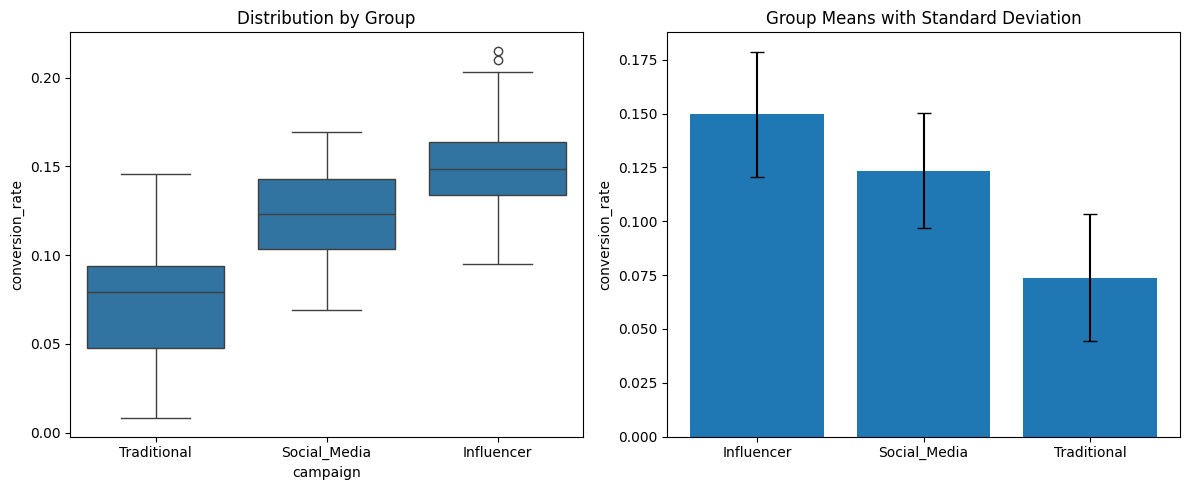

In [10]:
# Visualize sample data
plot_one_way_results(campaign_data, 'conversion_rate', 'campaign')

In [11]:
# Perform manual ANOVA
def one_way_anova_manual(data, value_col, group_col):
    """
    Perform one-way ANOVA calculations manually
    
    Parameters:
    - data: DataFrame
    - value_col: name of dependent variable column
    - group_col: name of grouping variable column
    
    Returns:
    - Dictionary with ANOVA results
    """
    groups = data[group_col].unique()
    n_groups = len(groups)
    n_total = len(data)
    
    # Calculate group means and overall mean
    group_means = data.groupby(group_col)[value_col].mean()
    overall_mean = data[value_col].mean()
    
    # Between-group sum of squares (SSB)
    ssb = 0
    for group in groups:
        group_data = data[data[group_col] == group]
        n_group = len(group_data)
        group_mean = group_means[group]
        ssb += n_group * (group_mean - overall_mean) ** 2
    
    # Within-group sum of squares (SSW)  
    ssw = 0
    for group in groups:
        group_data = data[data[group_col] == group]
        group_mean = group_means[group]
        ssw += ((group_data[value_col] - group_mean) ** 2).sum()
    
    # Degrees of freedom
    df_between = n_groups - 1
    df_within = n_total - n_groups
    df_total = n_total - 1
    
    # Mean squares
    msb = ssb / df_between
    msw = ssw / df_within
    
    # F-statistic
    f_stat = msb / msw
    
    # p-value
    p_value = 1 - stats.f.cdf(f_stat, df_between, df_within)
    
    return {
        'f_statistic': f_stat,
        'p_value': p_value,
        'df_between': df_between,
        'df_within': df_within,
        'ms_between': msb,
        'ms_within': msw,
        'ss_between': ssb,
        'ss_within': ssw,
        'group_means': group_means.to_dict()
    }


manual_results = one_way_anova_manual(campaign_data, 'conversion_rate', 'campaign')

print(f"\nManual ANOVA Results:")
print(f"F-statistic: {manual_results['f_statistic']:.4f}")
print(f"p-value: {manual_results['p_value']:.6f}")
print(f"Group means: {manual_results['group_means']}")

# Verify with scipy
groups = [group['conversion_rate'].values for name, group in campaign_data.groupby('campaign')]
f_stat, p_val = f_oneway(*groups)

print(f"\nSciPy verification:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.6f}")



Manual ANOVA Results:
F-statistic: 91.4841
p-value: 0.000000
Group means: {'Influencer': 0.14967382256706546, 'Social_Media': 0.12335957583006772, 'Traditional': 0.07387936261541266}

SciPy verification:
F-statistic: 91.4841
p-value: 0.000000


#### Two-way ANOVA



TWO-WAY ANOVA EXAMPLE: Campaign × Gender
Sample data:
   conversion_rate     campaign gender
0         0.023240  Traditional   Male
1         0.091898  Traditional   Male
2         0.065382  Traditional   Male
3         0.061062  Traditional   Male
4         0.076978  Traditional   Male

Data shape: (150, 3)


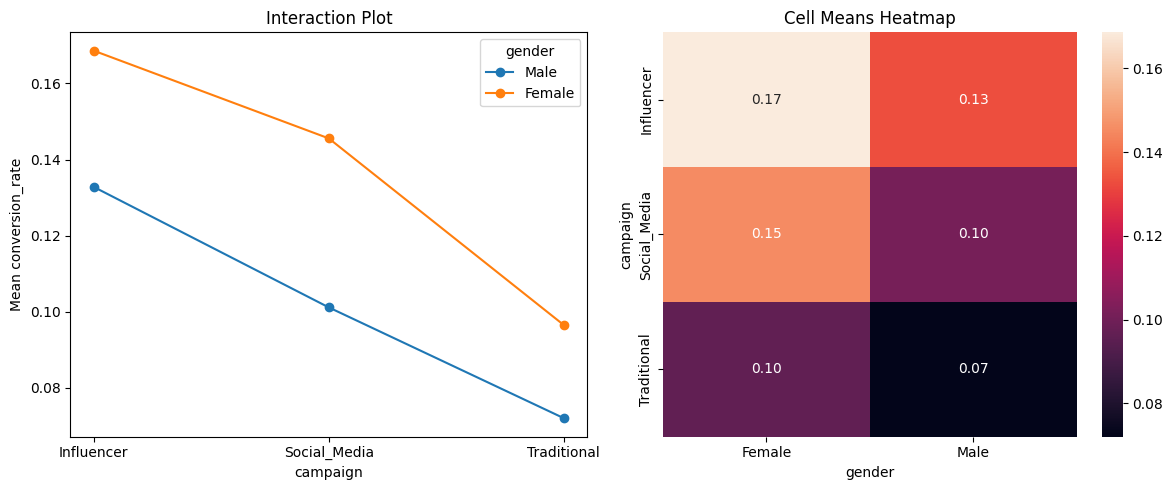

In [12]:
# =============================================================================
# EXAMPLE 2: TWO-WAY ANOVA - Campaign × Gender
# =============================================================================
print("\n\nTWO-WAY ANOVA EXAMPLE: Campaign × Gender")
print("=" * 50)

# Business scenario: Campaign effectiveness varies by gender
# Rows = Campaigns, Columns = Gender
cell_means_matrix = [
    [0.07, 0.09],  # Traditional: Male, Female
    [0.10, 0.14],  # Social Media: Male, Female  
    [0.13, 0.17]   # Influencer: Male, Female
]

campaigns = ['Traditional', 'Social_Media', 'Influencer']
genders = ['Male', 'Female']

two_way_data = generate_two_way_data(
    factor1_levels=campaigns,
    factor2_levels=genders,
    cell_means=cell_means_matrix,
    cell_std=0.025,
    n_per_cell=25
)

# Rename columns for business context
two_way_data.columns = ['conversion_rate', 'campaign', 'gender']

print("Sample data:")
print(two_way_data.head())
print(f"\nData shape: {two_way_data.shape}")

plot_two_way_results(two_way_data, 'conversion_rate', 'campaign', 'gender')

In [13]:
# Perform manual two-way ANOVA
def two_way_anova_manual(data, value_col, factor1_col, factor2_col):
    """
    Perform two-way ANOVA calculations manually
    
    Parameters:
    - data: DataFrame
    - value_col: name of dependent variable column
    - factor1_col: name of first factor column
    - factor2_col: name of second factor column
    
    Returns:
    - Dictionary with ANOVA results
    """
    # Basic setup
    n_total = len(data)
    overall_mean = data[value_col].mean()
    
    # Factor levels
    f1_levels = data[factor1_col].unique()
    f2_levels = data[factor2_col].unique()
    
    # Calculate means
    f1_means = data.groupby(factor1_col)[value_col].mean()
    f2_means = data.groupby(factor2_col)[value_col].mean()
    cell_means = data.groupby([factor1_col, factor2_col])[value_col].mean()
    cell_counts = data.groupby([factor1_col, factor2_col])[value_col].count()
    
    # Sum of squares calculations
    
    # Total SS
    ss_total = ((data[value_col] - overall_mean) ** 2).sum()
    
    # Factor A (main effect)
    ss_a = 0
    for level in f1_levels:
        level_data = data[data[factor1_col] == level]
        n_level = len(level_data)
        level_mean = f1_means[level]
        ss_a += n_level * (level_mean - overall_mean) ** 2
    
    # Factor B (main effect)  
    ss_b = 0
    for level in f2_levels:
        level_data = data[data[factor2_col] == level]
        n_level = len(level_data)
        level_mean = f2_means[level]
        ss_b += n_level * (level_mean - overall_mean) ** 2
    
    # Interaction (A × B)
    ss_ab = 0
    for f1 in f1_levels:
        for f2 in f2_levels:
            cell_data = data[(data[factor1_col] == f1) & (data[factor2_col] == f2)]
            if len(cell_data) > 0:
                n_cell = len(cell_data)
                cell_mean = cell_means[(f1, f2)]
                f1_mean = f1_means[f1]
                f2_mean = f2_means[f2]
                ss_ab += n_cell * (cell_mean - f1_mean - f2_mean + overall_mean) ** 2
    
    # Error (within cells)
    ss_error = 0
    for f1 in f1_levels:
        for f2 in f2_levels:
            cell_data = data[(data[factor1_col] == f1) & (data[factor2_col] == f2)]
            if len(cell_data) > 0:
                cell_mean = cell_means[(f1, f2)]
                ss_error += ((cell_data[value_col] - cell_mean) ** 2).sum()
    
    # Degrees of freedom
    df_a = len(f1_levels) - 1
    df_b = len(f2_levels) - 1  
    df_ab = df_a * df_b
    df_error = n_total - len(f1_levels) * len(f2_levels)
    
    # Mean squares
    ms_a = ss_a / df_a
    ms_b = ss_b / df_b
    ms_ab = ss_ab / df_ab
    ms_error = ss_error / df_error
    
    # F-statistics
    f_a = ms_a / ms_error
    f_b = ms_b / ms_error
    f_ab = ms_ab / ms_error
    
    # p-values
    p_a = 1 - stats.f.cdf(f_a, df_a, df_error)
    p_b = 1 - stats.f.cdf(f_b, df_b, df_error)
    p_ab = 1 - stats.f.cdf(f_ab, df_ab, df_error)
    
    return {
        'factor1_f': f_a, 'factor1_p': p_a,
        'factor2_f': f_b, 'factor2_p': p_b, 
        'interaction_f': f_ab, 'interaction_p': p_ab,
        'factor1_means': f1_means.to_dict(),
        'factor2_means': f2_means.to_dict(),
        'cell_means': cell_means.to_dict()
    }


two_way_results = two_way_anova_manual(two_way_data, 'conversion_rate', 'campaign', 'gender')

print(f"\nTwo-Way ANOVA Results:")
print(f"Campaign main effect - F: {two_way_results['factor1_f']:.4f}, p: {two_way_results['factor1_p']:.6f}")
print(f"Gender main effect - F: {two_way_results['factor2_f']:.4f}, p: {two_way_results['factor2_p']:.6f}")
print(f"Interaction effect - F: {two_way_results['interaction_f']:.4f}, p: {two_way_results['interaction_p']:.6f}")

print(f"\nCampaign means: {two_way_results['factor1_means']}")
print(f"Gender means: {two_way_results['factor2_means']}")


Two-Way ANOVA Results:
Campaign main effect - F: 79.8368, p: 0.000000
Gender main effect - F: 65.4059, p: 0.000000
Interaction effect - F: 1.7905, p: 0.170580

Campaign means: {'Influencer': 0.1507052464089445, 'Social_Media': 0.12335321687840003, 'Traditional': 0.08426750008536839}
Gender means: {'Female': 0.1368912543862477, 'Male': 0.10199272119556092}


In [14]:
def compare_anova_results(data, value_col, factor1_col, factor2_col):
    """
    Compare manual ANOVA with statsmodels results
    """
    print("=" * 60)
    print("TWO-WAY ANOVA COMPARISON: Manual vs Statsmodels")
    print("=" * 60)
    
    # Manual calculation
    manual_results = two_way_anova_manual(data, value_col, factor1_col, factor2_col)
    
    # Statsmodels calculation - ensure factors are strings
    data_copy = data.copy()
    data_copy[factor1_col] = data_copy[factor1_col].astype(str)
    data_copy[factor2_col] = data_copy[factor2_col].astype(str)
    
    formula = f'{value_col} ~ {factor1_col} + {factor2_col} + {factor1_col}:{factor2_col}'
    model = ols(formula, data=data_copy).fit()
    anova_table = anova_lm(model, typ=2)  # Type II sum of squares
    
    # Display comparison
    print(f"\n📊 MANUAL RESULTS:")
    print(f"   {factor1_col.title()}: F={manual_results['factor1_f']:.4f}, p={manual_results['factor1_p']:.6f}")
    print(f"   {factor2_col.title()}: F={manual_results['factor2_f']:.4f}, p={manual_results['factor2_p']:.6f}")
    print(f"   Interaction: F={manual_results['interaction_f']:.4f}, p={manual_results['interaction_p']:.6f}")
    
    print(f"\n📈 STATSMODELS RESULTS:")
    print(f"   {factor1_col.title()}: F={anova_table['F'].iloc[0]:.4f}, p={anova_table['PR(>F)'].iloc[0]:.6f}")
    print(f"   {factor2_col.title()}: F={anova_table['F'].iloc[1]:.4f}, p={anova_table['PR(>F)'].iloc[1]:.6f}")
    print(f"   Interaction: F={anova_table['F'].iloc[2]:.4f}, p={anova_table['PR(>F)'].iloc[2]:.6f}")
    
    # Check if results match
    tolerance = 1e-10
    f_match = (abs(manual_results['factor1_f'] - anova_table['F'].iloc[0]) < tolerance and
               abs(manual_results['factor2_f'] - anova_table['F'].iloc[1]) < tolerance and
               abs(manual_results['interaction_f'] - anova_table['F'].iloc[2]) < tolerance)
    
    p_match = (abs(manual_results['factor1_p'] - anova_table['PR(>F)'].iloc[0]) < tolerance and
               abs(manual_results['factor2_p'] - anova_table['PR(>F)'].iloc[1]) < tolerance and
               abs(manual_results['interaction_p'] - anova_table['PR(>F)'].iloc[2]) < tolerance)
    
    print(f"\n✅ VALIDATION:")
    print(f"   F-statistics match: {'Yes' if f_match else 'No'}")
    print(f"   P-values match: {'Yes' if p_match else 'No'}")
    
    if f_match and p_match:
        print("   🎉 Manual implementation is correct!")
    else:
        print("   ⚠️  Discrepancies found - check implementation")
    
    return manual_results, anova_table

# Run comparison
manual_results, statsmodels_table = compare_anova_results(
    two_way_data, 'conversion_rate', 'campaign', 'gender'
)

TWO-WAY ANOVA COMPARISON: Manual vs Statsmodels

📊 MANUAL RESULTS:
   Campaign: F=79.8368, p=0.000000
   Gender: F=65.4059, p=0.000000
   Interaction: F=1.7905, p=0.170580

📈 STATSMODELS RESULTS:
   Campaign: F=79.8368, p=0.000000
   Gender: F=65.4059, p=0.000000
   Interaction: F=1.7905, p=0.170580

✅ VALIDATION:
   F-statistics match: Yes
   P-values match: Yes
   🎉 Manual implementation is correct!
